In [4]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import math 
import argparse
import yaml

# Setando Variáveis

In [5]:
image_file = "img/resized.png"
data_file = "img/file"
#nomeVideo = "img/parking_lot_1.mp4"
nomeVideo = "img/parking_ifma_480p.mp4"
videoSaida = "img/output.mp4"

# Definindo Funções e Classes

In [9]:
def draw_contours(image,
                  coordinates,
                  label,
                  font_color,
                  border_color= (255,0,0),
                  line_thickness=1,
                  font=cv2.FONT_HERSHEY_SIMPLEX,
                  font_scale=0.5):
    cv2.drawContours(image,
                         [coordinates],
                         contourIdx=-1,
                         color=border_color,
                         thickness=2,
                         lineType=cv2.LINE_8)
    moments = cv2.moments(coordinates)

    center = (int(moments["m10"] / moments["m00"]) - 3,
              int(moments["m01"] / moments["m00"]) + 3)

    cv2.putText(image,
                    label,
                    center,
                    font,
                    font_scale,
                    font_color,
                    line_thickness,
                    cv2.LINE_AA)


class CoordinatesGenerator:
    KEY_RESET = ord("r")
    KEY_QUIT = ord("q")

    def __init__(self, image, output, color):
        self.output = output
        self.caption = image
        self.color = color

        self.image = cv2.imread(image).copy()
        #self.image = image.copy()
        self.click_count = 0
        self.ids = 0
        self.coordinates = []
        # = Cria Janela com dimensões livres
        #cv2.WINDOW_GUI_EXPANDED
        cv2.namedWindow(self.caption, cv2.WINDOW_NORMAL)
        cv2.setMouseCallback(self.caption, self.__mouse_callback)

    def generate(self):
        while True:
            cv2.imshow(self.caption, self.image)
            key = cv2.waitKey(0)

            if key == CoordinatesGenerator.KEY_RESET:
                self.image = self.image.copy()
            elif key == CoordinatesGenerator.KEY_QUIT:
                break
        cv2.destroyWindow(self.caption)

    def __mouse_callback(self, event, x, y, flags, params):

        if event == cv2.EVENT_LBUTTONDOWN:
            self.coordinates.append((x, y))
            self.click_count += 1

            if self.click_count >= 4:
                self.__handle_done()

            elif self.click_count > 1:
                self.__handle_click_progress()

        cv2.imshow(self.caption, self.image)

    def __handle_click_progress(self):
        cv2.line(self.image, self.coordinates[-2], self.coordinates[-1], (255, 0, 0), 1)

    def __handle_done(self):
        cv2.line(self.image,
                     self.coordinates[2],
                     self.coordinates[3],
                     self.color,
                     1)
        cv2.line(self.image,
                     self.coordinates[3],
                     self.coordinates[0],
                     self.color,
                     1)

        self.click_count = 0

        coordinates = np.array(self.coordinates)

        self.output.write("-\n          id: " + str(self.ids) + "\n          coordinates: [" +
                          "[" + str(self.coordinates[0][0]) + "," + str(self.coordinates[0][1]) + "]," +
                          "[" + str(self.coordinates[1][0]) + "," + str(self.coordinates[1][1]) + "]," +
                          "[" + str(self.coordinates[2][0]) + "," + str(self.coordinates[2][1]) + "]," +
                          "[" + str(self.coordinates[3][0]) + "," + str(self.coordinates[3][1]) + "]]\n")

        draw_contours(self.image, coordinates, str(self.ids + 1), (255,255,255))

        for i in range(0, 4):
            self.coordinates.pop()

        self.ids += 1

# Obter as coordenadas da Imagem 


In [10]:
if image_file is not None:
    #Coordenadas Salvas Em arquivo .yaml
    with open(data_file, "w+") as points:
            generator = CoordinatesGenerator(image_file, points, (255,0,0))
            generator.generate()
    #Leitura e passagem de Coordenadas para Lista poinnts
    with open(data_file, "r") as data:
        points = yaml.load(data)

# Pontos Obtidos


In [11]:
points

[{'coordinates': [[328, 441], [499, 409], [412, 227], [264, 289]], 'id': 0}]

# Detecção de Carro

In [12]:
#https://github.com/shaanhk/New-GithubTest/blob/master/cars.xml
#https://www.geeksforgeeks.org/opencv-python-program-vehicle-detection-video-frame
#https://raw.githubusercontent.com/abhi-kumar/CAR-DETECTION/master/cas4.xml

# Classificador de Carros  Treinado com caracteristicas de alguns objetos que queremos identificar (xml)
car_cascade = cv2.CascadeClassifier('cars.xml')   
car_cascade2 = cv2.CascadeClassifier('cas4.xml')  ##Modelo De Classificação Não muito bom

# Processando Video

In [15]:
config = {'save_video': False,
          'text_overlay': True,
          'parking_overlay': True,
          'parking_id_overlay': False,
          'parking_detection': True,
          'min_area_motion_contour': 60,
          'park_sec_to_wait': 3,
          'start_frame': 0} #35000


carros = []
# Set capture device or file
cap = cv2.VideoCapture(nomeVideo)
# print cap.get(5) 
video_info = {'fps':    cap.get(cv2.CAP_PROP_FPS),
              'width':  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
              'num_of_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}
cap.set(cv2.CAP_PROP_POS_FRAMES, config['start_frame']) # jump to frame

# Define the codec and create VideoWriter object
if config['save_video']:
    fourcc = cv2.VideoWriter_fourcc('D','I','V','X')# options: ('P','I','M','1'), ('D','I','V','X'), ('M','J','P','G'), ('X','V','I','D')
    out = cv2.VideoWriter(fn_out, -1, 25.0, #video_info['fps'], 
                          (video_info['width'], video_info['height']))


 #(parking space polygons)
 
parking_data = points
parking_contours = []
parking_bounding_rects = []
parking_mask = []
for park in parking_data:
    points2 = np.array(park['coordinates'])
    rect = cv2.boundingRect(points2)
    points_shifted = points2.copy()
    points_shifted[:,0] = points2[:,0] - rect[0] # shift contour to roi
    points_shifted[:,1] = points2[:,1] - rect[1]
    parking_contours.append(points2)
    parking_bounding_rects.append(rect)
    mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), [points_shifted], contourIdx=-1,
                            color=255, thickness=-1, lineType=cv2.LINE_8)
    mask = mask==255
    parking_mask.append(mask)

parking_status = [False]*len(parking_data)
parking_buffer = [None]*len(parking_data)


while(cap.isOpened()):   
    spot = 0
    occupied = 0 
    # Read frame-by-frame    
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame = cap.read()    
    if ret == False:
        print("Capture Error")
        break
    
    # frame_gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()
    
    cars = car_cascade.detectMultiScale(frame_out, 1.8, 2)
    for (x,y,w,h) in cars: 
        cv2.rectangle(frame_out,(x,y),(x+w,y+h),(0,0,255),2)
        cv2.putText(frame_out,"Carro", (x,y) , cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

            
    
    
    if config['parking_detection']:        
        for ind, park in enumerate(parking_data):
            roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calculation   
            # print np.std(roi_gray)
            
            
           
            #print rect
            #print points2
            
            roi_gray_2 = frame_out[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])]
            
            for (x,y,w,h) in cars: 
                cv2.rectangle(frame_out,(x,y),(x+w,y+h),(0,0,255),2)
                cv2.putText(frame_out,"Carro", (x,y) , cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

            
            points2[:,0] = points2[:,0] - rect[0] # shift contour to roi
            points2[:,1] = points2[:,1] - rect[1]
            
            
            status = np.std(roi_gray) < 22 and np.mean(roi_gray) > 53
            # If detected a change in parking status, save the current time
            if status != parking_status[ind] and parking_buffer[ind]==None:
                parking_buffer[ind] = video_cur_pos
            # If status is still different than the one saved and counter is open
            elif status != parking_status[ind] and parking_buffer[ind]!=None:
                if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                    parking_status[ind] = status
                    parking_buffer[ind] = None
            # If status is still same and counter is open                    
            elif status == parking_status[ind] and parking_buffer[ind]!=None:
                #if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                parking_buffer[ind] = None                    
            # print(parking_status)
    if config['parking_overlay']:                    
        for ind, park in enumerate(parking_data):
            points2 = np.array(park['coordinates'])
            if parking_status[ind]: 
                color = (0,255,0)
                spot = spot+1
            else: 
                color = (0,0,255)
                occupied = occupied+1
            
            #rect = parking_bounding_rects[ind]
            #print rect 
           
            cv2.drawContours(frame_out, [points2], contourIdx=-1,
                             color=color, thickness=2, lineType=cv2.LINE_8)            
            moments = cv2.moments(points2)        
            centroid = (int(moments['m10']/moments['m00'])-3, int(moments['m01']/moments['m00'])+3)
            cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)

    # Draw Overlay
    if config['text_overlay']:
        cv2.rectangle(frame_out, (1, 5), (280, 90),(255,255,255), 85) 
        str_on_frame = "Frames: %d/%d" % (video_cur_frame, video_info['num_of_frames'])
        cv2.putText(frame_out, str_on_frame, (5,30), cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
                    0.7, (0,128,255), 2, cv2.LINE_AA)
        str_on_frame = "Livre: %d Ocupado: %d" % (spot, occupied)
        cv2.putText(frame_out, str_on_frame, (5,90), cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
                            0.7, (0,128,255), 2, cv2.LINE_AA)
 
            
    # write the output frame
    if config['save_video']:
        if video_cur_frame % 35 == 0: # take every 30 frames
            out.write(frame_out)    
    
    # Display video
    cv2.imshow('Vagas de Estacionamento', frame_out)
    cv2.waitKey(40)
    # cv2.imshow('background mask', bw)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump to frame


cap.release()
if config['save_video']: out.release()
cv2.destroyAllWindows()    

Capture Error


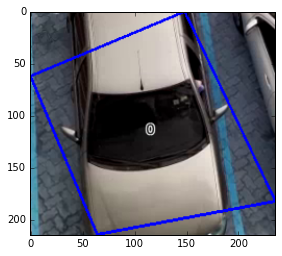

In [17]:
plt.imshow(roi_gray_2)
plt.show()

# TensorFlow

In [18]:
import tensorflow as tf,sys

## Escreve Frame Lido e Lê

In [40]:
image_path = 'frameTL.jpg'
cv2.imwrite(image_path, roi_gray_2)
image_data = tf.gfile.FastGFile(image_path, 'rb').read()


In [26]:
label_lines = [line.rstrip() for line in tf.gfile.GFile("/tf_files/retrained_labels.txt")]

In [27]:
with tf.gfile.FastGFile("/tf_files/retrained_graph.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name="") 

In [53]:
pontuacao = []
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
    predictions = sess.run(softmax_tensor,  {'DecodeJpeg/contents:0': image_data})
    
    
    top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
    
     
    for node_id in top_k:
        human_string= label_lines[node_id]
        score = predictions[0][node_id]
        pontuacao.append(score)
        print human_string, score

busy 0.9762689
free 0.023731152


# Função Classificadora Tensor Flow

In [60]:
def classificador(frame):
    image_path = 'frameTL.jpg'
    cv2.imwrite(image_path, frame)
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()

    label_lines = [line.rstrip() for line in tf.gfile.GFile("/tf_files/retrained_labels.txt")]
    
    with tf.gfile.FastGFile("/tf_files/retrained_graph.pb", 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name="") 
        
        
    pontuacao = []
    with tf.Session() as sess:
        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
        predictions = sess.run(softmax_tensor,  {'DecodeJpeg/contents:0': image_data})


        top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]


        for node_id in top_k:
            human_string= label_lines[node_id]
            score = predictions[0][node_id]
            pontuacao.append(score)
            #print human_string, score    

    return pontuacao

In [62]:
 r =classificador(roi_gray_2)

In [ ]:
config = {'save_video': False,
          'text_overlay': True,
          'parking_overlay': True,
          'parking_id_overlay': False,
          'parking_detection': True,
          'min_area_motion_contour': 60,
          'park_sec_to_wait': 3,
          'start_frame': 0} #35000


carros = []
# Set capture device or file
cap = cv2.VideoCapture(nomeVideo)
# print cap.get(5) 
video_info = {'fps':    cap.get(cv2.CAP_PROP_FPS),
              'width':  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
              'num_of_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}
cap.set(cv2.CAP_PROP_POS_FRAMES, config['start_frame']) # jump to frame

# Define the codec and create VideoWriter object
if config['save_video']:
    fourcc = cv2.VideoWriter_fourcc('D','I','V','X')# options: ('P','I','M','1'), ('D','I','V','X'), ('M','J','P','G'), ('X','V','I','D')
    out = cv2.VideoWriter(fn_out, -1, 25.0, #video_info['fps'], 
                          (video_info['width'], video_info['height']))


 #(parking space polygons)
 
parking_data = points
parking_contours = []
parking_bounding_rects = []
parking_mask = []
for park in parking_data:
    points2 = np.array(park['coordinates'])
    rect = cv2.boundingRect(points2)
    points_shifted = points2.copy()
    points_shifted[:,0] = points2[:,0] - rect[0] # shift contour to roi
    points_shifted[:,1] = points2[:,1] - rect[1]
    parking_contours.append(points2)
    parking_bounding_rects.append(rect)
    mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), [points_shifted], contourIdx=-1,
                            color=255, thickness=-1, lineType=cv2.LINE_8)
    mask = mask==255
    parking_mask.append(mask)

parking_status = [False]*len(parking_data)
parking_buffer = [None]*len(parking_data)


while(cap.isOpened()):   
    spot = 0
    occupied = 0 
    # Read frame-by-frame    
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame = cap.read()    
    if ret == False:
        print("Capture Error")
        break
    
    # frame_gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()
    
    cars = car_cascade.detectMultiScale(frame_out, 1.8, 2)
    for (x,y,w,h) in cars: 
        cv2.rectangle(frame_out,(x,y),(x+w,y+h),(0,0,255),2)
        cv2.putText(frame_out,"Carro", (x,y) , cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

            
    
    
    if config['parking_detection']:        
        for ind, park in enumerate(parking_data):
            roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calculation   
            
            roi_gray_2 = frame_out[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])]
            
            points2[:,0] = points2[:,0] - rect[0] # shift contour to roi
            points2[:,1] = points2[:,1] - rect[1]
            
            #Status Atualizado com TensorClassificador
            r = classificador(roi_gray_2)
            
            status = (r[0]>r[1])
            #status = np.std(roi_gray) < 22 and np.mean(roi_gray) > 53
            # If detected a change in parking status, save the current time
            if status != parking_status[ind] and parking_buffer[ind]==None:
                parking_buffer[ind] = video_cur_pos
            # If status is still different than the one saved and counter is open
            elif status != parking_status[ind] and parking_buffer[ind]!=None:
                if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                    parking_status[ind] = status
                    parking_buffer[ind] = None
            # If status is still same and counter is open                    
            elif status == parking_status[ind] and parking_buffer[ind]!=None:
                #if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                parking_buffer[ind] = None                    
            # print(parking_status)
    if config['parking_overlay']:                    
        for ind, park in enumerate(parking_data):
            points2 = np.array(park['coordinates'])
            if parking_status[ind]: 
                color = (0,255,0)
                spot = spot+1
            else: 
                color = (0,0,255)
                occupied = occupied+1
            
            #rect = parking_bounding_rects[ind]
            #print rect 
           
            cv2.drawContours(frame_out, [points2], contourIdx=-1,
                             color=color, thickness=2, lineType=cv2.LINE_8)            
            moments = cv2.moments(points2)        
            centroid = (int(moments['m10']/moments['m00'])-3, int(moments['m01']/moments['m00'])+3)
            cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)

    # Draw Overlay
    if config['text_overlay']:
        cv2.rectangle(frame_out, (1, 5), (280, 90),(255,255,255), 85) 
        str_on_frame = "Frames: %d/%d" % (video_cur_frame, video_info['num_of_frames'])
        cv2.putText(frame_out, str_on_frame, (5,30), cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
                    0.7, (0,128,255), 2, cv2.LINE_AA)
        str_on_frame = "Livre: %d Ocupado: %d" % (spot, occupied)
        cv2.putText(frame_out, str_on_frame, (5,90), cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
                            0.7, (0,128,255), 2, cv2.LINE_AA)
 
            
    # write the output frame
    if config['save_video']:
        if video_cur_frame % 35 == 0: # take every 30 frames
            out.write(frame_out)    
    
    # Display video
    cv2.imshow('Vagas de Estacionamento', frame_out)
    cv2.waitKey(40)
    # cv2.imshow('background mask', bw)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump to frame


cap.release()
if config['save_video']: out.release()
cv2.destroyAllWindows()    

In [63]:
r

[0.9762689, 0.023731152]

In [64]:
r[0]

0.9762689

In [65]:
status

False

In [ ]:
status = np.std(roi_gray) < 22 and np.mean(roi_gray) > 53

In [71]:
status = (r[0]>r[1])

In [72]:
status

True